In [126]:
import math
import numpy as np
import pandas as pd
import scipy as sp
import numpy.random as npr  
import scipy.stats as scs
import matplotlib.pyplot as plt
import numpy.random as npr
import seaborn as sns

from math import sqrt, exp
from pylab import plot, show, grid, xlabel, ylabel

In [127]:
# SVCJ parameters, from Hou et al.
mu      = 0.041
r       = mu
mu_y    = -0.084
sigma_y = 2.155
l       = 0.041
alpha   = 0.01
beta    = -0.132
rho     = 0.407
sigma_v = 0.008
rho_j   = -0.573
mu_v    = 0.62

kappa   = 1-beta
theta   = alpha / kappa

# v0      = 0.19**2 # where does this come from?
v0 = theta

In [128]:
npr.seed(202006)
dt      = 1/365.0 # dt
m       = int(365.0 * (1/dt)/365.0) # time horizon in days
n       = 100000

In [129]:
T      = m * dt
t      = np.linspace(0.0, 12, m+1)

In [130]:
w      = npr.standard_normal([n,m])
w2     = rho * w + sp.sqrt(1-rho**2) * npr.standard_normal([n,m])
z_v    = npr.exponential(mu_v, [n,m]) # mean = 1/lambda 
z_y    = npr.standard_normal([n,m]) * sigma_y + mu_y + rho_j * z_v
dj     = npr.binomial(1, l * dt, size=[n,m])

s      = np.empty([n,m+1])
ltv    = np.empty([n,m+1])
v      = np.empty([n,m+1])

In [131]:
#bitcoin value on 12/06/2020
s0 = 9425.92
ltv0 = 0.6

K = 0.9
D = 0.8

CS = ltv0*s0 

s[:,0] = s0 
ltv[:,0] = ltv0
v[:,0] = v0

In [132]:
for i in range(1,m+1):
#     v[:,i] = v[:,i-1] + kappa * (theta - np.maximum(0,v[:,i-1])) * dt + sigma_v * sp.sqrt(np.maximum(0,v[:,i-1])) * w2[:,i-1] + z_v[:,i-1] * dj[:,i-1]
    v[:,i] = v[:,i-1] + kappa * (theta - np.maximum(0,v[:,i-1])) * dt + sigma_v * sp.sqrt(np.maximum(0,v[:,i-1])) * w2[:,i-1] 

    s[:,i] = s[:,i-1] * (1 + (r - l * (mu_y + rho_j * mu_v)) * dt + sp.sqrt(v[:,i-1] * dt) * w[:,i-1]) + z_v[:,i-1] * dj[:,i-1]
    ltv[:,i] = CS*(1/s[:,i])

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


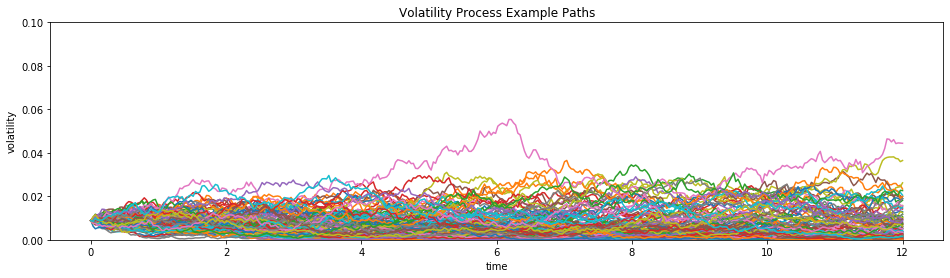

In [133]:
plt.figure(figsize = (16,4))

for k in range(100):
    plot(t, v[k])
    xlabel('time')
    ylabel('volatility')
    plt.title('Volatility Process Example Paths')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0,0.1))
    #plt.savefig('volapath.png', transparent=True)

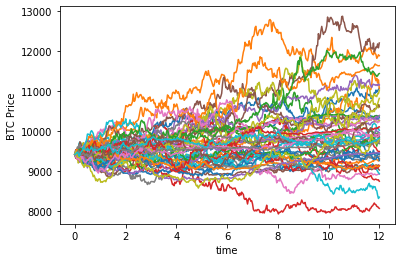

In [134]:
for k in range(50):
    plot(t,s[k])
    xlabel('time')
    ylabel('BTC Price')
    #plt.title('Volatility Process Example Paths')
    #plt.savefig('volapath.png', transparent=True)

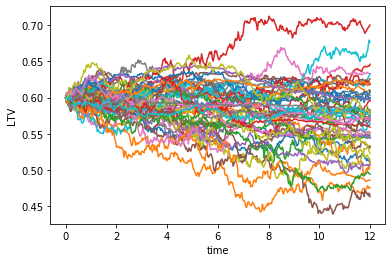

In [135]:
for k in range(50):
    plot(t,ltv[k])
    xlabel('time')
    ylabel('LTV')
    #plt.title('Volatility Process Example Paths')
    #plt.savefig('volapath.png', transparent=True)

In [136]:
y=np.argwhere(ltv>=0.9)
y[np.argwhere(y[:,1:]<=60)];

In [137]:
called = np.where((ltv>=0.9).sum(axis=1) > 0 )
called

(array([37459, 43594, 65719, 83912]),)

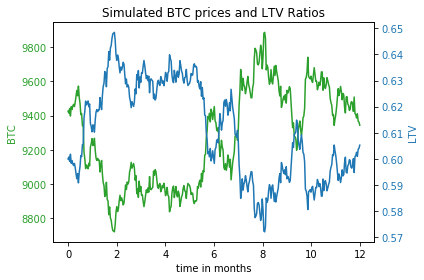

In [138]:
fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_xlabel('time in months')
ax1.set_ylabel('BTC', color=color)
ax1.plot(t, s[6092], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('LTV', color=color)  
ax2.plot(t, ltv[6092], color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.axhline(y=1.5, color='r', linestyle='-')

plt.title('Simulated BTC prices and LTV Ratios')
fig.tight_layout() 
plt.savefig('inverses.png', transparent=True)
plt.show()

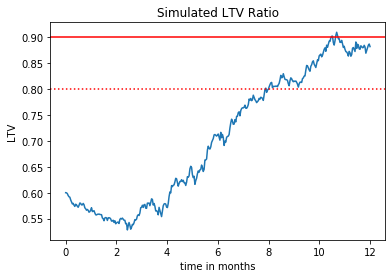

In [139]:
plot(t, ltv[37459])

xlabel('time in months')
ylabel('LTV')
plt.title('Simulated LTV Ratio')
plt.axhline(y=K, color='r', linestyle='-')
plt.axhline(y=0.8, color='r', linestyle='dotted')
plt.savefig('ltv.png', transparent=True)
#leg = plt.legend()
#grid(True)
show()

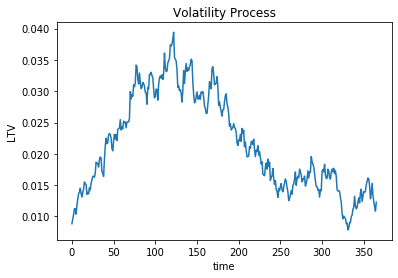

In [140]:
plot(v[37459])

xlabel('time')
ylabel('LTV')
plt.title('Volatility Process')
show()

In [19]:
print(ltv[6092,np.argwhere(ltv[6092]>=0.9)[0]], s[6092,np.argwhere(ltv[6092]>=0.9)[0]])

IndexError: index 0 is out of bounds for axis 0 with size 0

## Determine Value of Lending Contract

In [100]:
# function for calculating the payoff of each contract at time t
def payoff(S, LTV, B0, K, l, t, T, r, v=0):
    B = (1+l)*B0             # total repayment
    CS_usd = B0/LTV[v,0]     # collateral size
    CS_btc = CS_usd/S[v,0]   # amount of bitcoin needed
    
    # find time points where LTV hits threshold
    tau = np.argwhere(LTV[v] >= K)
    
    if len(tau) == 0:
        F = exp(-r*(T-t)/T)*B
        
    else:
        F = exp(-r*((tau[0]-t)/T))*(CS_btc*S[v,tau[0]])
        
    return F

In [101]:
### contract parameters ###
# borrowed amount in USD
B0 = 10000

# pre-agreed interest rate
z = 0.1

# repayment
B = B0*(1+z)

# annual discounting factor
r = 0.01

# time point of view (in days)
t = m
K = 0.9

In [102]:
# calculate payoff for all contracts
F = np.empty((n))

for k in range(n):
    F[k]=payoff(s, ltv, B0, K, z, t, m, r, k)

In [103]:
# empirical mean of all contracts
mean = 1/n*sum(F)

# empirical variance
variance = 1/n*(sum((F-mean)**2))
sd = sqrt(variance)

print('mean payoff: ', round(mean, 3), sep="")
print('variance: ', round(variance, 3), ' with standard deviation ', round(sd, 3), sep="" )

mean payoff: 11000.005
variance: 0.591 with standard deviation 0.769


In [104]:
print('Minimal Payoff: ', round(min(F),3), sep="")
print('Maximal Payoff: ', round(max(F),3), sep="")

Minimal Payoff: 11000.0
Maximal Payoff: 11165.665


In [105]:
# which path gives maximum payoff
print(np.argwhere(F == max(F)))

# liquidization day of this particular path
np.argwhere(ltv[np.argwhere(F == max(F))] >= K)[0,2]

[[83912]]


180

In [106]:
gain = len(np.argwhere(F > B0*(1+z)))
loss = len(np.argwhere(F < B0))
print('Lender loses money in ', loss, ' cases, and earns in ', gain, ' cases.', sep="")

Lender loses money in 0 cases, and earns in 4 cases.


In [107]:
# therefore, the expected value of the contract is
V = exp(-r)*mean

# discounted value of the pre-agreed payback
b = exp(-r)*B

print('V = ', round(V, 2), sep="")
print('b = ', round(b, 2), sep="")

V = 10890.55
b = 10890.55


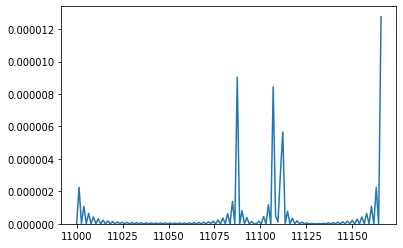

In [108]:
sns.distplot(F, hist=False);

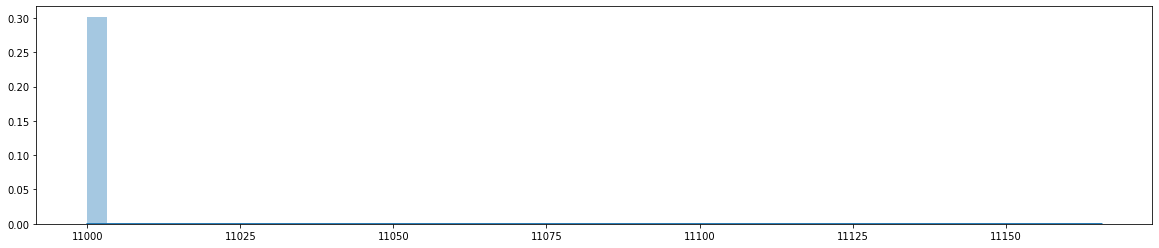

In [109]:
plt.figure(figsize = (20,4))
bins = 50
sns.distplot(F, bins=bins)


(10900, 11200)

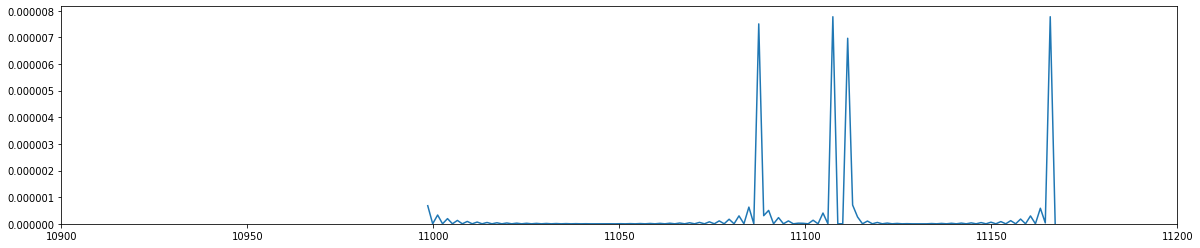

In [125]:
plt.figure(figsize = (20,4))
bw = 0.5
sns.kdeplot(F, bw=bw)
plt.xlim((10900,11200))

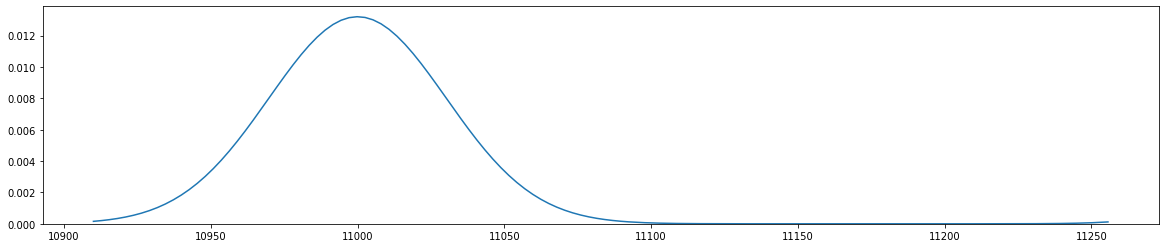

In [111]:
plt.figure(figsize = (20,4))
bw = 30
sns.kdeplot(F, bw=bw)

In [141]:
# Payoff function from Francis
def payoff_1(B0, contract_interest, init_LTV, S, K, T):
    # B0               : borrowed amount
    # contract_interest: interest rate defined in contract
    # init_LTV.        : initial Loan to Value Ratio
    # S                : Bitcoin price in USD
    # K                : LTV threshold
    # T                : Contract length in day
    
    B = (1+contract_interest)*B0  # total repayment at T
    CS_usd = B0/init_LTV          # collateral size in USD
    CS_btc = CS_usd/S[0]

    LTV = B0/(CS_btc*S)          # LTV Process

    # find time points where LTV hits threshold
    tau = np.argwhere(LTV >= K)

    if len(tau) == 0:
        called = False
        F = (np.exp(-risk_free*T/365)*B)

    else:
        called = True
        F = (np.exp(-risk_free*tau[0]/365)*CS_btc*S[tau[0]])[0]
    return F, called

In [145]:
s[0].shape

(366,)

In [158]:
B0 = 10000
contract_interest = 0.1
init_LTV = 0.7
T        = 366
K        = 0.9
risk_free = 0.01

results = []
for btc in s:
    results.append(payoff_1(B0, contract_interest, init_LTV, btc, K, T))
    
results = pd.DataFrame(results)
results.columns = ['F', 'Called']

In [159]:
called   = results.loc[results.Called == True ,"F"]
finished = results.loc[results.Called == False,"F"]

In [160]:
print("contract value at t0:", np.mean(results.F))
print("Probability of call loan",np.mean(results.Called))

contract value at t0: 10890.337016323148
Probability of call loan 0.00103


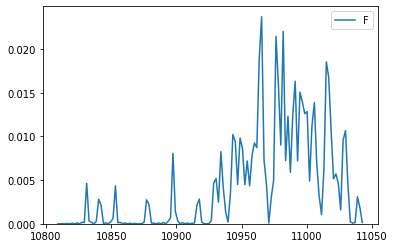

In [161]:
bw = 1
sns.kdeplot(called, bw=bw)

In [162]:
np.mean(finished)

10890.249804141127